# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

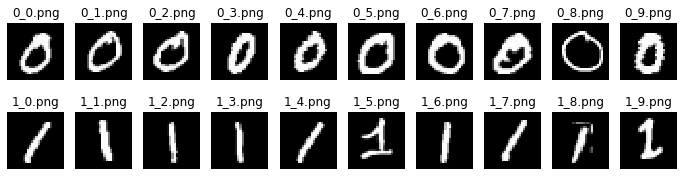

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [3]:
from scipy import ndimage
import cv2
import numpy as np
import skimage.transform as transform
from skimage.morphology import skeletonize
from sklearn.decomposition import PCA

### 1.2 Fourier descriptors
Add your implementation and discussion

To apply the Fourier descriptors, we need the coordinates of the pixels of the contours of the objects

In [14]:
def get_contour(in_im, is_zeros = False):
    #plt.imshow(zeros_im[num,:,:], cmap='gray')
    #plt.show()
    #print("Thresholding")
    #threshold
    imtest = in_im.copy()
    imtest[imtest[:,:] >= 50] = 255
    imtest[imtest[:,:] < 50] = 0
    #plt.imshow(imtest, cmap='gray')
    #plt.show()

    #print("Padding")
    padded = np.zeros((68,68))
    padded[20:48, 20:48] = imtest
    #plt.imshow(padded, cmap='gray')
    #plt.show()

    #print("Opening")
    #opening
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(padded, cv2.MORPH_OPEN, kernel)
    plt.imshow(opening, cmap='gray')
    plt.show()
    print("Heeeey")
    
    if is_zeros:
        #print("Closing")
        #morph
        #closing
        kernel = np.ones((15,15),np.uint8)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
      #  plt.imshow(closing, cmap='gray')
      #  plt.show()
    else :
        kernel = np.ones((4,4),np.uint8)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    #print("Gradient")
    #grad
    kernel = np.ones((2,2),np.uint8)
    gradient = cv2.morphologyEx(closing, cv2.MORPH_GRADIENT, kernel)
    #plt.imshow(gradient, cmap='gray')
    #plt.show()


    #print("unpad")
    outim = gradient[20:48,20:48]
    #plt.imshow(outim, cmap='gray')
    #plt.show()
    return outim


In [6]:
for i in range(10):
    m_contour = get_contour(ones_im[i,:,:], False)

In [7]:
#get curves of contours (with pixels in the right order)
def get_curve(im):
    neighbours = np.array([[1,0], [0,1], [-1,0], [0,-1]])
    all_points = np.argwhere(im==255)
    curve = np.zeros(all_points.shape)
    curve[0,:] = all_points[0,:] #first point of contour
    #remove first point
    all_points = all_points[1:,:]
    for i in range(curve.shape[0] - 1):
        #find the next point
        for j in range(4):
            next_logic = all_points == (curve[i,:] + neighbours[j,:])
            if next_logic.all(axis = 1).any():
                curve[i+1,:] = all_points[next_logic.all(axis = 1)]
                all_points = all_points[~next_logic.all(axis = 1)] #remove it from original list
                break
                
    return curve   

We have the contours of the digits, we now have to compute Fourier's descriptors to classify them:
- We first simply try to take the amplitude of f1 and f2. Avoiding f0 should allow for this solution to be translation independant, and using only the amplitude should allow to avoid effect of rotation and starting point of the contour

In [8]:
#fourier descriptors

def feature_from_fourier(contour):
    incomplex = contour[:,0] + 1j * contour[:,1]
    transform = np.fft.fft(incomplex)
    #only f1, f2 and f3
    transform = transform[0:5]
    #normalize 
    #transform = transform * np.exp(1j * np.angle(transform)) 
    #use only their amplitude (independent of rotation and choice of strating point)
    transform = np.absolute(transform)
    #use ratio (independant on scaling)
    feature = np.array([transform[1]/transform[0], transform[2]/transform[0]])
    return feature

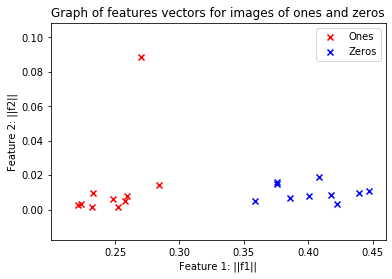

In [9]:
#finally, compute feature vectors for all images and plot them
def return_features(im, is_zero=False):
    features = np.zeros((im.shape[0],2))
    for i in range(im.shape[0]):
        contour = get_contour(im[i,:,:], is_zero)
        curve = get_curve(contour)
        features[i,:] = feature_from_fourier(curve)
    return features
    
feature_ones = np.zeros((10,2))
feature_zeros = np.zeros((10,2))
for i in range(10):
    contour = get_contour(ones_im[i,:,:], False)
    curve = get_curve(contour)
    feature_ones[i,:] = feature_from_fourier(curve)
    
    contour = get_contour(zeros_im[i,:,:], True)
    curve = get_curve(contour)
    feature_zeros[i,:] = feature_from_fourier(curve)
    
    
fig, ax = plt.subplots()
ax.scatter(feature_ones[:,0], feature_ones[:,1], marker='x', color='r', label="Ones")
ax.scatter(feature_zeros[:,0], feature_zeros[:,1], marker='x', color='b', label="Zeros")
ax.set_xlabel("Feature 1: ||f1||")
ax.set_ylabel("Feature 2: ||f2||")
plt.legend(loc=0)
ax.set_title('Graph of features vectors for images of ones and zeros')
plt.show()  


It appears that this choise of feature vector is quite efficient to separate the zeros and the ones. One outlier is the fifth one-image, which is not surprising as it is drawn quite differently from the others. It also appears, that feature 1 appears to be enough to separate class 1 (appart from the fifth one) from class 0. 
We can now try to rotate the images and see if the feature vectors are indeed invariant in rotation:

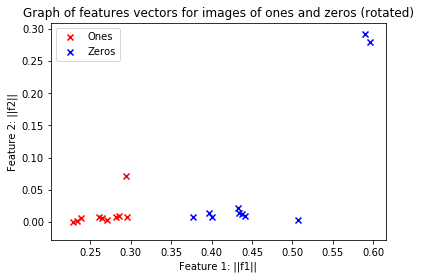

In [10]:
# rotate every image by a random angle between 0 and 2pi
angles0 = np.random.rand(1,10) * 360
angles1 = np.random.rand(1,10) * 360

zeros_rot = np.zeros(zeros_im.shape)
ones_rot = np.zeros(ones_im.shape)

feature_ones = np.zeros((10,2))
feature_zeros = np.zeros((10,2))

    
for i in range(10):
    zeros_rot[i,:,:] = transform.rotate(zeros_im[i,:,:], angles0[:,i], preserve_range=True)
    contour = get_contour(zeros_rot[i,:,:], is_zeros=True)
    curve = get_curve(contour)
    feature_zeros[i,:] = feature_from_fourier(curve)
    
    ones_rot[i,:,:] = transform.rotate(ones_im[i,:,:], angles1[:,i], preserve_range=True)
    contour = get_contour(ones_rot[i,:,:], is_zeros=False)
    curve = get_curve(contour)
    feature_ones[i,:] = feature_from_fourier(curve)
    
    
fig, ax = plt.subplots()
ax.scatter(feature_ones[:,0], feature_ones[:,1], marker='x', color='r', label="Ones")
ax.scatter(feature_zeros[:,0], feature_zeros[:,1], marker='x', color='b', label="Zeros")
ax.set_xlabel("Feature 1: ||f1||")
ax.set_ylabel("Feature 2: ||f2||")
plt.legend(loc=0)
ax.set_title('Graph of features vectors for images of ones and zeros (rotated)')
plt.show()  
   
    

    

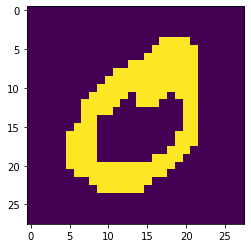

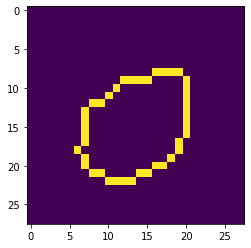

41


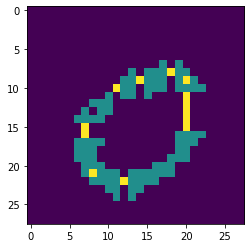

In [21]:
#explore skeletons
imtest = zeros_im[2,:,:].copy()
imtest[imtest[:,:] >= 50] = 255
imtest[imtest[:,:] < 50] = 0
plt.imshow(imtest)
plt.show()
skel = skeletonize(imtest, method='lee')
plt.imshow(skel)
plt.show()
#count num of points in skeleton
count = (skel==255).sum()
print(count)
#corners
dst=cv2.cornerHarris(skel,2,3,0.01)
skel[dst>0.01*dst.max()]=126
plt.imshow(skel)
plt.show()


### 1.3 Additional method(s)
Add your implementation and discussion

We try to apply PCA to the problem. Simply put, it consists in projecting each image (seen as a 28*28=784 component vector) on the two vectors which which maximize the variance of the whole dataset. The projection on these two vectors become our feature vector. 

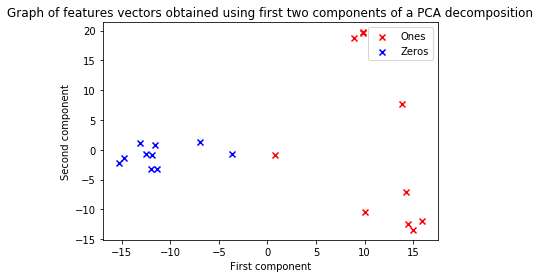

In [27]:
#normalize images and reshape them as vectors
ones_normalized = ones_im.astype('float')
zeros_normalized = zeros_im.astype('float')

ones_normalized -= np.expand_dims(ones_normalized.mean((1,2)),(1,2))
ones_normalized /= np.expand_dims(ones_normalized.std((1,2)),(1,2))
ones_normalized = ones_normalized.reshape((10,784))

zeros_normalized -= np.expand_dims(zeros_normalized.mean((1,2)),(1,2))
zeros_normalized /= np.expand_dims(zeros_normalized.std((1,2)),(1,2))
zeros_normalized = zeros_normalized.reshape((10,784))

#apply PCA
pca = PCA(n_components=2)
x=pca.fit_transform(np.concatenate((zeros_normalized, ones_normalized), axis=0))

#plot features
fig, ax = plt.subplots()
ax.scatter(x[10:,0], x[10:,1], marker='x', color='r', label="Ones")
ax.scatter(x[0:10,0], x[0:10,1], marker='x', color='b', label="Zeros")
ax.set_xlabel("First component")
ax.set_ylabel("Second component")
plt.legend(loc=0)
ax.set_title('Graph of features vectors obtained using first two components of a PCA decomposition')
plt.show()  


#function doing the same thing, to reuse it in part 2
def extract_feature_with_PCA(im_set):
    dataset = np.zeros((len(im_set)*10, 784))
    for i in range(len(im_set)):
        tmp = im_set[i].astype('float')
        tmp -= np.expand_dims(tmp.mean((1,2)),(1,2))
        tmp /= np.expand_dims(tmp.std((1,2)),(1,2))
        dataset[i*10:i*10+10,:] = tmp.reshape((10,784))
    #apply PCA
    pca = PCA(n_components=2)
    x=pca.fit_transform(dataset)
    #return projection
    return x

We can observe that using this method, the ones are well clustered on one side of the graph, and although the cluster of zeros is a little less compact, both are still linearly separable.

## My test of moments

Still using moments, we also tried another approach, simply using two moments as features in the feature vector. From cv2, we used the functions cv2.moments and cv2.HuMoments. We try three different kind of moments:
- centered moments: defined on slide 40 of lecture 4, invariant only in translation
- centered and invariant in rotation moments: defined on slide 41 of lecture 4, invariant in translation and rotation
- hu moments: defined on slide 42 of lecture 4, invariant in translation, rotation and scaling

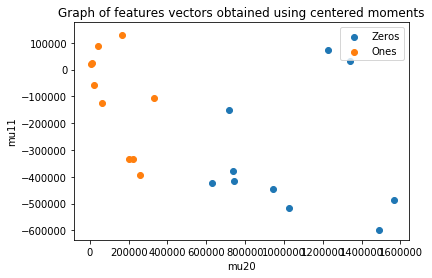

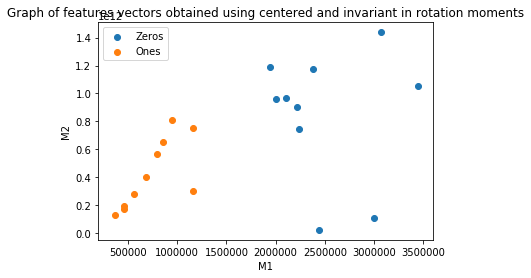

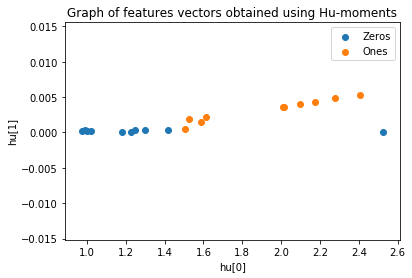

In [73]:
#get binary images with simple thresholding
zeros_bin = zeros_im.copy()
zeros_bin[zeros_bin[:,:,:] >= 50] = 255
zeros_bin[zeros_bin[:,:,:] < 50] = 0
ones_bin = ones_im.copy()
ones_bin[ones_bin[:,:,:] >= 50] = 255
ones_bin[ones_bin[:,:,:] < 50] = 0

# quick preprocessing with closing to remove some noise
kernel = np.ones((2,2),np.uint8)
for i in range(10):
    ones_bin[i,:,:] = cv2.morphologyEx(ones_bin[i,:,:], cv2.MORPH_OPEN, kernel)
    zeros_bin[i,:,:] = cv2.morphologyEx(zeros_bin[i,:,:], cv2.MORPH_OPEN, kernel)

    
#intialize feature vectors for three kinds of moments
#centered moments
moments_zeros = np.zeros((10,2))
moments_ones = np.zeros((10,2))

#centered and invariant in rotation moments
moments_rot_invariant_zeros = np.zeros((10,2))
moments_rot_invariant_ones = np.zeros((10,2))

#hu moments
humoments_zeros = np.zeros((10,2))
humoments_ones = np.zeros((10,2))


#compute them using cv2
for i in range(10):
    mom = cv2.moments(zeros_bin[i,:,:])
    moments_rot_invariant_zeros[i,0] = mom['mu20'] + mom['mu02']
    moments_rot_invariant_zeros[i,1] = (mom['mu20'] - mom['mu02'])**2 + 4 * mom['mu11']**2
    moments_zeros[i,0] = mom['mu20']
    moments_zeros[i,1] = mom['mu11']
    humoments_zeros[i,:] = 1000*cv2.HuMoments(mom)[:2,:].squeeze()
    
    mom = cv2.moments(ones_bin[i,:,:])
    moments_rot_invariant_ones[i,0] = mom['mu20'] + mom['mu02']
    moments_rot_invariant_ones[i,1] = (mom['mu20'] - mom['mu02'])**2 + 4 * mom['mu11']**2
    moments_ones[i,0] = mom['mu20']
    moments_ones[i,1] = mom['mu11']
    humoments_ones[i,:] = 1000*cv2.HuMoments(mom)[:2,:].squeeze()
        
#plot    
fig, ax = plt.subplots()
ax.scatter(moments_zeros[:,0],moments_zeros[:,1], label = 'Zeros')
ax.scatter(moments_ones[:,0],moments_ones[:,1], label = 'Ones')
plt.xlabel('mu20')
plt.ylabel('mu11')
ax.legend()
ax.set_title('Graph of features vectors obtained using centered moments')
plt.show()

fig, ax = plt.subplots()
ax.scatter(moments_rot_invariant_zeros[:,0],moments_rot_invariant_zeros[:,1], label = 'Zeros')
ax.scatter(moments_rot_invariant_ones[:,0],moments_rot_invariant_ones[:,1], label = 'Ones')
plt.xlabel('M1')
plt.ylabel('M2')
ax.legend()
ax.set_title('Graph of features vectors obtained using centered and invariant in rotation moments')
plt.show()

fig, ax = plt.subplots()
ax.scatter(humoments_zeros[:,0],humoments_zeros[:,1], label = 'Zeros')
ax.scatter(humoments_ones[:,0],humoments_ones[:,1], label = 'Ones')
plt.xlabel('hu[0]')
plt.ylabel('hu[1]')
ax.legend()
ax.set_title('Graph of features vectors obtained using Hu-moments')
plt.show()


We can observe that two moments can be used as features to discriminate between the two classes. When using centered moments and invariant to rotation moments, we can observe that both classes are linearly separable, although the intra-class variance appears to be high. In the hu-moments case, inter-class variation appears limited, and one zero-outlier causes the two classe to not be completely linearly separable, this last kind of moments is not really effective at discriminating between the two classes.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

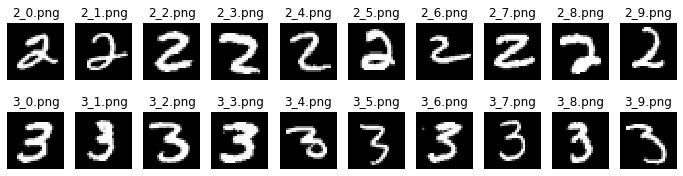

In [72]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

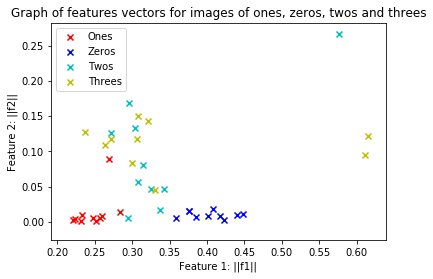

In [77]:
#Compute feature vectors for new digits and plot them
feature_ones = return_features(ones_im)
feature_zeros = return_features(zeros_im, True)
feature_twos = return_features(twos_im)
feature_threes = return_features(threes_im)

    
    
fig, ax = plt.subplots()
ax.scatter(feature_ones[:,0], feature_ones[:,1], marker='x', color='r', label="Ones")
ax.scatter(feature_zeros[:,0], feature_zeros[:,1], marker='x', color='b', label="Zeros")
ax.scatter(feature_twos[:,0], feature_twos[:,1], marker='x', color='c', label="Twos")
ax.scatter(feature_threes[:,0], feature_threes[:,1], marker='x', color='y', label="Threes")

ax.set_xlabel("Feature 1: ||f1||")
ax.set_ylabel("Feature 2: ||f2||")
plt.legend(loc=0)
ax.set_title('Graph of features vectors for images of ones, zeros, twos and threes')
plt.show()  

It appears that using the same two Fourier's descriptor as in part 1 doesn't allow to discriminate between twos and threes, and neither between the new images and the previous ones.

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

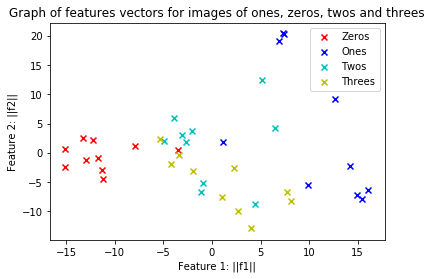

In [93]:
#pca
x = extract_feature_with_PCA((zeros_im, ones_im, twos_im, threes_im))


fig, ax = plt.subplots()
ax.scatter(x[0:10,0], x[0:10,1], marker='x', color='r', label="Zeros")
ax.scatter(x[10:20,0], x[10:20,1], marker='x', color='b', label="Ones")
ax.scatter(x[20:30,0], x[20:30,1], marker='x', color='c', label="Twos")
ax.scatter(x[30:40,0], x[30:40,1], marker='x', color='y', label="Threes")

ax.set_xlabel("Feature 1: ||f1||")
ax.set_ylabel("Feature 2: ||f2||")
plt.legend(loc=0)
ax.set_title('Graph of features vectors for images of ones, zeros, twos and threes')
plt.show()  

Using the PCA method, that was working quite well to discriminate between zeros and ones, doesn't work either when adding the twos and threes. Here again, it ppears that two features is not enough to discriminate between the four classes.